# Machine Learning Modelling and Prediction

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from shutil import copyfile

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

/home/diegues/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Defining functions to print wrong predictions for comparison and to create the environment in the machine in order to use images in the models.

In [3]:
def printWrongPreds(preds, targets):
    df = pd.DataFrame()
    images = []
    predictions = []
    targets_ = []
    if(type(preds) == pd.DataFrame):          
        predsClass = preds.idxmax(axis=1)
        targetsClass = targets.idxmax(axis=1)  
        for i in range(0,len(predsClass)):
            if(predsClass[i] != targetsClass[i]):
                images.append(targets.index[i])
                predictions.append(predsClass[i])
                targets_.append(targetsClass[i])
                print('Image:', targets.index[i],'\t\tPrediction:', predsClass[i], '\tTarget:', targetsClass[i])
    else:
        for i in range(0,len(preds)):
            if(preds[i] != targets['level3'][i]):
                images.append(targets.index[i])
                predictions.append(preds[i])
                targets_.append(targets['level3'][i])
                print('Image:', targets.index[i],'\t\tPrediction:', preds[i], '\tTarget:', targets['level3'][i])
    df['image'] = images
    df['prediction'] = predictions
    df['target'] = targets_
    return df

def createDirectoryEnvironment(train_data, train_targets, val_data, val_targets, path):
    trainpath = path + 'train/'
    valpath = path + 'validation/'
    if(os.listdir() == 2):
        return trainpath,valpath
    if(not os.path.exists(trainpath)):
        os.mkdir(trainpath)
    if(not os.path.exists(valpath)):
        os.mkdir(valpath)
        
    classes = train_targets.columns.append(val_targets.columns).drop_duplicates()  
    for c in classes:
        train_class = trainpath + c + '/'
        val_class = valpath + c + '/'
        if(not os.path.exists(train_class)):
            os.mkdir(train_class)
        if(not os.path.exists(val_class)):
            os.mkdir(val_class)
            
    for f in train_data.index.values:
        copyfile(path + '../' + 'LabeledData' + '/' + f, trainpath + train_targets.loc[f].idxmax(axis = 1) + '/' + f)
    for f in val_data.index.values:
        copyfile(path + '../' + 'LabeledData' + '/' + f, valpath + val_targets.loc[f].idxmax(axis = 1) + '/' + f)
    
    return trainpath, valpath

def createTestDirectory(test_data, folder_path):
    test_path = folder_path + 'test/unknown/'
    if(not os.path.exists(test_path)):
        os.mkdir(test_path)
    for f in test_data.index.values:
        copyfile(folder_path + f[:f.find('frame')-1] + '/' + f, test_path + f)
    return test_path

def splitImagesByTargetSize(path_dir, target_size):
    for folder in os.listdir(path_dir):
        for file in os.listdir(path_dir + folder):
            img = cv2.imread(path_dir + folder + "/" + file)
            height, width, channels = img.shape
            count = 0
            for i in np.arange(0,height//target_size[0],0.5):
                for j in np.arange(0, width//target_size[1], 0.5):
                    if target_size[0] * i > height and target_size[1] * j > width:
                        break
                    if target_size[0] * (i+1) <= height and target_size[1] * (j+1) <= width:
                        subfig = img[int(target_size[0] * i):int(target_size[0] * (i+1)),int(target_size[1] * j):int(target_size[1] * (j+1))]
                        cv2.imwrite(path_dir + folder + "/" + file.split('.')[0] + '-' + str(count) + '.' + file.split('.')[1], subfig)
                        count += 1
                    elif target_size[0] * (i+1) <= height and target_size[1] * (j+1) > width:
                        subfig = img[int(target_size[0] * i):int(target_size[0] * (i+1)),width - target_size[1]:width]
                        cv2.imwrite(path_dir + folder + "/" + file.split('.')[0] + '-' + str(count) + '.' + file.split('.')[1], subfig)
                        count += 1
                    elif target_size[0] * (i+1) > height and target_size[1] * (j+1) <= width:
                        subfig = img[height - target_size[0]:height,int(target_size[1] * j):int(target_size[1] * (j+1))]
                        cv2.imwrite(path_dir + folder + "/" + file.split('.')[0] + '-' + str(count) + '.' + file.split('.')[1], subfig)
                        count += 1
                    elif target_size[0] * (i+1) > height and target_size[1] * (j+1) > width:
                        subfig = img[height - target_size[0]:height,width - target_size[1]:width]
                        cv2.imwrite(path_dir + folder + "/" + file.split('.')[0] + '-' + str(count) + '.' + file.split('.')[1], subfig)
                        count += 1

def splitImagesByAspectRatio(path):
    for folder in os.listdir(path):
        for file in os.listdir(path + folder):
            img = cv2.imread(path + folder + "/" + file)
            height, width, channels = img.shape
            aspect_ratio = width/height
            createSquaredImages(img, aspect_ratio, path,folder,file)

def createSquaredImages(img, aspect_ratio, path,folder,file):
    if(aspect_ratio == 4/3):
        square_shape = img.shape[0] // 3
    else:
        square_shape = img.shape[0] // 9
    count = 0
    for i in np.arange(0,img.shape[0],square_shape):
        for j in np.arange(0, img.shape[1],square_shape):
            subfig = img[i:i+square_shape,j:j+square_shape]
            cv2.imwrite(path + folder + "/" + file.split('.')[0] + '-' + str(count) + '.' + file.split('.')[1], subfig)
            count += 1               

## Data Import and Train Test split

Here we import the data and process it with one-hot encoding, dropping the columns that did not add relevance to the models. Also, we're predicting (for now) only the level 3 of the EUNIS taxonomy, as the amount of data is still short.

In [4]:
folder_path = "/home/diegues/Desktop/ProcessedImages/"
#data = pd.read_csv(folder_path + "sampled_data.csv")
data = pd.read_csv("sampled_data.csv")
filenames = data['filename']
targets = data['level3']

# one-hot encoding
targets_ohe = pd.get_dummies(targets.replace(['A3.1', 'A4.1'], 'A3.1-A4.1').replace(['A3.7', 'A4.7'], 'A3.7-A4.7'))
print(targets_ohe.head())
#species_ohe = pd.get_dummies(data['species'])

# dealing with NaNs
data = data.drop(['roll', 'pitch', 'level1', 'level2', 'level3', 'level4', 
                  'level5', 'level6', 'AphiaID', 'EunisName', 'EunisCode', 
                  'date', 'timestamp', 'species'],
                 axis = 1)

X = data.groupby('filename').max()
Y_ohe = pd.concat([filenames,targets_ohe], axis = 1).groupby('filename').max()
Y_cat = pd.concat([filenames,targets], axis = 1).groupby('filename').max()

print(pd.value_counts(Y_cat.level3).to_frame().reset_index())

# tts
train_X_ohe, test_X_ohe, train_Y_ohe, test_Y_ohe = train_test_split(X, Y_ohe, test_size = 0.3, random_state=47)
train_X_cat, test_X_cat, train_Y_cat, test_Y_cat = train_test_split(X, Y_cat, test_size = 0.3, random_state=47)

   A3.1-A4.1  A3.7-A4.7  A5.1  A5.2  A5.4
0          1          0     0     0     0
1          1          0     0     0     0
2          1          0     0     0     0
3          1          0     0     0     0
4          1          0     0     0     0
  index  level3
0  A5.1     178
1  A3.7      91
2  A4.1      89
3  A3.1      89
4  A4.7      88
5  A5.2      85
6  A5.4      34


## Fitting and Training the Models

### Random Forest

In [7]:
rf = RandomForestClassifier(n_estimators = 1000)
rf.fit(train_X_ohe, train_Y_ohe)
predictions_rf = rf.predict(test_X_ohe)
predictions_rf = pd.DataFrame(predictions_rf)
predictions_rf.columns = test_Y_ohe.columns.values
print('RF:\t',rf.score(test_X_ohe, test_Y_ohe))
failed_rf = printWrongPreds(predictions_rf, test_Y_ohe)
print(pd.DataFrame([(name,round(value,3)) for name,value in zip(X.columns,rf.feature_importances_)]))

RF:	 0.9247311827956989
Image: 132143_forcadinho-np3_frame295.jpg 		Prediction: A3.1 	Target: A4.1
Image: 132143_forcadinho-np3_frame1394.jpg 		Prediction: A3.1 	Target: A5.1
Image: 113610_cam_survey_1_frame311.jpg 		Prediction: A3.7 	Target: A3.1
Image: 104728_cam-np3_frame69.jpg 		Prediction: A4.7 	Target: A4.1
Image: 113610_cam_survey_1_frame557.jpg 		Prediction: A3.7 	Target: A3.1
Image: 105317_cam-np3_frame404.jpg 		Prediction: A4.7 	Target: A4.1
Image: 105317_cam-np3_frame269.jpg 		Prediction: A4.7 	Target: A4.1
Image: 113610_cam_survey_1_frame571.jpg 		Prediction: A3.7 	Target: A3.1
Image: 132143_forcadinho-np3_frame2910.jpg 		Prediction: A3.7 	Target: A3.1
Image: 132143_forcadinho-np3_frame1129.jpg 		Prediction: A3.1 	Target: A5.1
Image: 113610_cam_survey_1_frame92.jpg 		Prediction: A3.7 	Target: A3.1
Image: 132143_forcadinho-np3_frame4062.jpg 		Prediction: A3.1 	Target: A3.7
Image: 125355_forcadinho-np3_frame255.jpg 		Prediction: A4.1 	Target: A5.1
Image: 105317_cam-np3_frame8

In [8]:
test_2 = pd.read_csv('/home/diegues/Downloads/unknown2-targets.csv')
entropy_data = pd.read_csv('/home/diegues/Downloads/unknown2.csv')['entropy']
test_2_Y = test_2.level3
test_2_Y.index = test_2.filename
test_2_Y.head()

test_2_X = pd.concat([test_2[['latitude', 'longitude', 'depth']], entropy_data], axis=1)
test_2_X.index = test_2.filename
#test_2_X.head()
test_2_Y.head()

filename
105317_cam-np3_frame1347.jpg    A3.7
105317_cam-np3_frame1352.jpg    A3.7
105317_cam-np3_frame1390.jpg    A3.1
105317_cam-np3_frame1468.jpg    A4.1
105317_cam-np3_frame1473.jpg    A4.1
Name: level3, dtype: object

In [9]:
test_2_Y = pd.get_dummies(test_2_Y)
rf.score(test_2_X, test_2_Y)

ValueError: inconsistent shapes

### Support Vector Machines

In [10]:
svm = svm.SVC()
svm.fit(train_X_cat, train_Y_cat.values.ravel())
preds_svm = svm.predict(test_X_cat)
print('SVM:\t',accuracy_score(test_Y_cat, preds_svm))
#failed_svm = printWrongPreds(preds_svm, test_Y_cat) # too many wrong predictions to print it

SVM:	 0.6182795698924731


In [42]:
accuracy_score(test_2_Y, svm.predict(test_2_X))

0.16511318242343542

This result confirms our suspicions: SVM will not have good results in this problem unless we add more data and variability in the classifications.

### Neural Networks
#### sklearn

In [44]:
scaler = StandardScaler()
scaler.fit(train_X_cat)

train_X_scaled = scaler.transform(train_X_cat)
test_X_scaled = scaler.transform(test_X_cat)

mlp = MLPClassifier(hidden_layer_sizes=(4096,4096,1000))
mlp.fit(train_X_scaled,train_Y_cat.values.ravel())

predictions_nn = mlp.predict(test_X_scaled)
print('sklearn NN:\t',accuracy_score(test_Y_cat,predictions_nn))
failed_nn = printWrongPreds(predictions_nn, test_Y_cat)


sklearn NN:	 0.8836363636363637
Image: 125355_forcadinho-np3_frame255.jpg 		Prediction: A4.1 	Target: A5.1
Image: 113610_cam_survey_1_frame1573.jpg 		Prediction: A5.4 	Target: A5.1
Image: 113610_cam_survey_1_frame696.jpg 		Prediction: A5.1 	Target: A3.1
Image: 113610_cam_survey_1_frame698.jpg 		Prediction: A5.1 	Target: A3.1
Image: 113610_cam_survey_1_frame67.jpg 		Prediction: A3.7 	Target: A3.1
Image: 132143_forcadinho-np3_frame3012.jpg 		Prediction: A3.1 	Target: A3.7
Image: 113610_cam_survey_1_frame360.jpg 		Prediction: A3.7 	Target: A3.1
Image: 132143_forcadinho-np3_frame1598.jpg 		Prediction: A3.1 	Target: A3.7
Image: 125355_forcadinho-np3_frame1721.jpg 		Prediction: A4.1 	Target: A5.1
Image: 125355_forcadinho-np3_frame1056.jpg 		Prediction: A3.1 	Target: A4.1
Image: 125355_forcadinho-np3_frame1106.jpg 		Prediction: A3.1 	Target: A4.1
Image: 113610_cam_survey_1_frame1101.jpg 		Prediction: A5.1 	Target: A3.1
Image: 113610_cam_survey_1_frame709.jpg 		Prediction: A5.1 	Target: A3.1
I

In [50]:
scaler = StandardScaler()
scaler.fit(test_2_X)
accuracy_score(test_2_Y, mlp.predict(scaler.transform(test_2_X)))

0.14247669773635152

#### Keras

In [12]:
scaler_keras = StandardScaler()
scaler_keras.fit(train_X_ohe)

X_train_scaled = scaler_keras.transform(train_X_ohe)
X_test_scaled = scaler_keras.transform(test_X_ohe)

model = Sequential()
model.add(Dense(4096, activation='relu', input_dim=4))
model.add(Dropout(0.2))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(6, activation='softmax')) 

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train_scaled, train_Y_ohe, epochs=500,validation_data=(X_test_scaled,test_Y_ohe))
predskeras_nn = pd.DataFrame(model.predict(X_test_scaled))
predskeras_nn.columns = test_Y_ohe.columns.values
score = model.evaluate(X_test_scaled, test_Y_ohe)

print('Keras NN:\t', score)
failed_keras = printWrongPreds(predskeras_nn,test_Y_ohe)

Train on 434 samples, validate on 186 samples
Epoch 1/500


ResourceExhaustedError: OOM when allocating tensor of shape [1000,6] and type float
	 [[Node: training/Adam/zeros_14 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [1000,6] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'training/Adam/zeros_14', defined at:
  File "/home/diegues/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/diegues/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/home/diegues/anaconda3/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/home/diegues/anaconda3/lib/python3.6/asyncio/base_events.py", line 1431, in _run_once
    handle._run()
  File "/home/diegues/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-cc1f5f97f6a6>", line 20, in <module>
    model.fit(X_train_scaled, train_Y_ohe, epochs=500,validation_data=(X_test_scaled,test_Y_ohe))
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/keras/engine/training.py", line 1013, in fit
    self._make_train_function()
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/keras/engine/training.py", line 497, in _make_train_function
    loss=self.total_loss)
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/keras/optimizers.py", line 458, in get_updates
    vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/keras/optimizers.py", line 458, in <listcomp>
    vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 699, in zeros
    v = tf.zeros(shape=shape, dtype=tf_dtype, name=name)
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1626, in zeros
    output = fill(shape, constant(zero, dtype=dtype), name=name)
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2717, in fill
    "Fill", dims=dims, value=value, name=name)
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/diegues/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [1000,6] and type float
	 [[Node: training/Adam/zeros_14 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [1000,6] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


In [55]:
scaler_keras = StandardScaler()
scaler_keras.fit(test_2_X)

model.evaluate(scaler_keras.transform(test_2_X), test_2_Y)[1]

751/751 [==============================] - 0s 82us/step


0.1571238350257099

### Convolutional Neural Networks - adaptation of the VGG

#### Preping the images

In [5]:
images_path = '/home/diegues/Desktop/ProcessedImages/SampledData/'

train_dir, val_dir = createDirectoryEnvironment(train_X_ohe, train_Y_ohe, test_X_ohe, test_Y_ohe, images_path)
target_size = (224,224)


train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        images_path + 'train',  
        target_size=target_size, 
        batch_size=1,
        class_mode='categorical', 
        shuffle=True) 

validation_generator = test_datagen.flow_from_directory(
        images_path + 'validation',
        target_size=target_size,
        batch_size=1,
        class_mode='categorical', 
        shuffle=True)


Found 457 images belonging to 5 classes.
Found 197 images belonging to 5 classes.


#### VGG Architecture 


In [6]:
vgg16 = Sequential()

vgg16.add(Conv2D(64,(3,3),activation='relu', input_shape=(224,224,3), padding='same'))
vgg16.add(Conv2D(64,(3,3),activation='relu', padding='same'))
vgg16.add(MaxPooling2D((2,2), (2,2)))

vgg16.add(Conv2D(128,(3,3),activation='relu', padding='same'))
vgg16.add(Conv2D(128,(3,3),activation='relu', padding='same'))
vgg16.add(MaxPooling2D((2,2), (2,2)))

vgg16.add(Conv2D(256,(3,3),activation='relu', padding='same'))
vgg16.add(Conv2D(256,(3,3),activation='relu', padding='same'))
vgg16.add(Conv2D(256,(3,3),activation='relu', padding='same'))
vgg16.add(MaxPooling2D((2,2), (2,2)))


vgg16.add(Conv2D(512,(3,3),activation='relu', padding='same'))
vgg16.add(Conv2D(512,(3,3),activation='relu', padding='same'))
vgg16.add(Conv2D(512,(3,3),activation='relu', padding='same'))
vgg16.add(MaxPooling2D((2,2), (2,2)))

vgg16.add(Flatten())
vgg16.add(Dense(256, activation='relu'))
vgg16.add(Dropout(0.5))
vgg16.add(Dense(256, activation='relu'))
vgg16.add(Dropout(0.75))
vgg16.add(Dense(5, activation='softmax'))

vgg16_optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
vgg16.compile(loss='categorical_crossentropy',
              optimizer=vgg16_optimizer,
              metrics=['accuracy'])
vgg16.summary()
tbCallBack = TensorBoard(log_dir='./Graph/firstvgg', histogram_freq=0, write_graph=True, write_images=True)
esCallBack = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=3, min_lr=0.000000001)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 256)       295168    
__________

In [7]:

from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
plot_model(vgg16,
           to_file='firstvgg.png',
           show_shapes=True,
           show_layer_names=True,
           rankdir='TB'
)

#### Fitting the model

In [ ]:
vgg16_history = vgg16.fit_generator(
        train_generator,
        steps_per_epoch=len(train_X_ohe),
        epochs=200,
        validation_data=validation_generator,
        validation_steps=len(test_X_ohe), 
        callbacks=[tbCallBack,reduce_lr,esCallBack])
vgg16.save_weights('weights/vgg16_1024_1024_7.h5')
#vgg16.load_weights('/home/diegues/git/AutomaticHabitatMapping/src/vgg16_1024_1024_7.h5')

Epoch 1/200
457/457 [==============================] - 58s 126ms/step - loss: 13.4416 - acc: 0.1641 - val_loss: 13.7454 - val_acc: 0.1472
Epoch 2/200
457/457 [==============================] - 55s 121ms/step - loss: 13.4729 - acc: 0.1641 - val_loss: 13.7454 - val_acc: 0.1472
Epoch 3/200
457/457 [==============================] - 56s 122ms/step - loss: 13.0849 - acc: 0.1882 - val_loss: 13.7454 - val_acc: 0.1472
Epoch 4/200
457/457 [==============================] - 54s 118ms/step - loss: 13.0144 - acc: 0.1926 - val_loss: 13.7454 - val_acc: 0.1472
Epoch 5/200
457/457 [==============================] - 55s 119ms/step - loss: 13.3318 - acc: 0.1729 - val_loss: 13.7454 - val_acc: 0.1472
Epoch 6/200
457/457 [==============================] - 56s 124ms/step - loss: 13.5787 - acc: 0.1575 - val_loss: 13.7454 - val_acc: 0.1472
Epoch 7/200
457/457 [==============================] - 54s 119ms/step - loss: 13.7550 - acc: 0.1466 - val_loss: 13.7454 - val_acc: 0.1472
Epoch 8/200
457/457 [=============

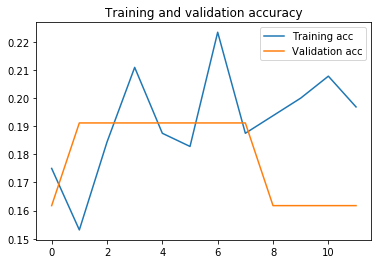

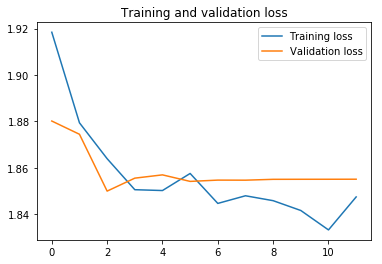

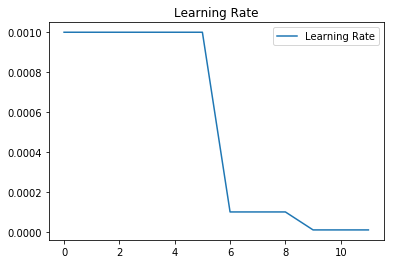

In [81]:
acc = vgg16_history.history['acc']
val_acc = vgg16_history.history['val_acc']
loss = vgg16_history.history['loss']
val_loss = vgg16_history.history['val_loss']
lr = vgg16_history.history['lr']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('train_val_acc.jpg')

plt.figure()
 
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('train_val_loss.jpg')
plt.show()

plt.figure()
 
plt.plot(epochs, lr, label='Learning Rate')
plt.title('Learning Rate')
plt.legend()
plt.savefig('learning_rate.jpg')
plt.show()

In [31]:
images_path = '/home/diegues/Desktop/ProcessedImages/SampledData/'
train_dir, val_dir = createDirectoryEnvironment(train_X_ohe, train_Y_ohe, test_X_ohe, test_Y_ohe, images_path)

target_size = (256,256)
#splitImagesByTargetSize(train_dir, target_size)
#splitImagesByTargetSize(val_dir, target_size)

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        images_path + 'train',  
        target_size=(256, 256), 
        batch_size=2,
        class_mode='categorical') 

validation_generator = test_datagen.flow_from_directory(
        images_path + 'validation',
        target_size=(256, 256),
        batch_size=2,
        class_mode='categorical')

Found 8320 images belonging to 7 classes.
Found 3575 images belonging to 7 classes.


In [32]:
# DeepSense AI NOAA competition approach

dsaiNOAA = Sequential()

dsaiNOAA.add(Conv2D(32,(3,3),activation='relu', input_shape=(256,256,3), padding='same'))
dsaiNOAA.add(Conv2D(64,(3,3),activation='relu', padding='same'))
dsaiNOAA.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
dsaiNOAA.add(Dropout(.25))

dsaiNOAA.add(Conv2D(64,(3,3),activation='relu', padding='same'))
dsaiNOAA.add(Conv2D(128,(3,3),activation='relu', padding='same'))
dsaiNOAA.add(Conv2D(128,(3,3),activation='relu', padding='same'))
dsaiNOAA.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
dsaiNOAA.add(Dropout(.25))

dsaiNOAA.add(Conv2D(256,(3,3),activation='relu', padding='same'))
dsaiNOAA.add(Conv2D(256,(3,3),activation='relu', padding='same'))
dsaiNOAA.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
dsaiNOAA.add(Dropout(.25))

dsaiNOAA.add(Conv2D(256,(3,3),activation='relu', padding='same'))
dsaiNOAA.add(Conv2D(256,(3,3),activation='relu', padding='same'))
dsaiNOAA.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
dsaiNOAA.add(Dropout(.5))

dsaiNOAA.add(Conv2D(256,(3,3),activation='relu', padding='same'))
dsaiNOAA.add(Conv2D(256,(3,3),activation='relu', padding='same'))
dsaiNOAA.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
dsaiNOAA.add(Dropout(.5))

dsaiNOAA.add(Flatten())
dsaiNOAA.add(Dense(4096, activation='relu'))
dsaiNOAA.add(Dense(4096, activation='relu'))
dsaiNOAA.add(Dense(7, activation='softmax'))

dsaiNOAA.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
dsaiNOAA.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 256, 256, 64)      18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 127, 127, 64)      0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 127, 127, 64)      36928     
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 127, 127, 128)     73856     
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 127, 127, 128)     147584    
__________

In [ ]:
dsaiNOAA_history = dsaiNOAA.fit_generator(
        train_generator,
        steps_per_epoch=8320 // 2,
        epochs=200,
        validation_data=validation_generator,
        validation_steps=3575 // 2, 
callbacks=[tbCallBack,reduce_lr,esCallBack])
dsaiNOAA.save_weights('dsaiNOAA.h5')
#dsaiNOAA.load_weights('dsaiNOAA.h5')

## Predicting Unlabeled Data

Getting the data from the folders

In [12]:
folders = []
for folder in [f for f in os.listdir(folder_path) if os.path.isdir(folder_path + f)]:
    if folder[0] in '0123456789':
        folders.append(folder)
folders.sort()
print(folders)  

['104728_cam-np3', '105317_cam-np3', '113610_cam_survey_1', '125355_forcadinho-np3', '132143_forcadinho-np3']


In [13]:
df0 = pd.DataFrame()
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df3 = pd.DataFrame()
df4 = pd.DataFrame()

i = 0

for f in folders:
    datafile = folder_path + f + "/" + f + ".csv"
    if not os.path.exists(datafile):
        print(datafile + "doesn't exist!")
        break
    data = pd.read_csv(datafile)
    depth = data.altitude + data.depth
    data = data.drop(['altitude', 'depth'], axis = 1)
    data['depth'] = depth
    targetsfile = folder_path + f + "/" + f + "-targets.csv"
    if not os.path.exists(targetsfile):
        print(targetsfile + "doesn't exist!")
        continue
    targets = pd.read_csv(targetsfile,
                          names=['filename', 'date', 'longitude', 'latitude', 'depth', 'EunisCode', 'EunisName', 'level1', 'level2', 'level3', 'level4', 'level5', 'level6', 
                                 'species', 'AphiaID'])[1:]
    targets = targets.drop(['date', 'longitude', 'latitude', 'depth'], axis=1)
    join_dfs = pd.merge(data, targets, on='filename', how='outer')
    empty_targets = join_dfs[join_dfs['EunisCode'].isnull()]
    if i == 0:
        df0 = empty_targets
        filenames = df0['filename']
        df0 = df0.drop(['roll', 'pitch', 'level1', 'level2', 'level3', 'level4',
          'level5', 'level6', 'AphiaID', 'EunisName', 'EunisCode', 
          'date', 'timestamp', 'species'], axis = 1)
        df0 = df0.groupby('filename').max()
        i += 1
    elif i == 1:
        df1 = empty_targets
        filenames = df1['filename']
        df1 = df1.drop(['roll', 'pitch', 'level1', 'level2', 'level3', 'level4',
          'level5', 'level6', 'AphiaID', 'EunisName', 'EunisCode', 
          'date', 'timestamp', 'species'], axis = 1)
        df1 = df1.groupby('filename').max()
        i += 1
    elif i == 2:
        df2 = empty_targets
        filenames = df2['filename']
        df2 = df2.drop(['roll', 'pitch', 'level1', 'level2', 'level3', 'level4',
          'level5', 'level6', 'AphiaID', 'EunisName', 'EunisCode', 
          'date', 'timestamp', 'species'], axis = 1)
        df2 = df2.groupby('filename').max()
        i += 1
    elif i == 3:
        df3 = empty_targets
        filenames = df3['filename']
        df3 = df3.drop(['roll', 'pitch', 'level1', 'level2', 'level3', 'level4',
          'level5', 'level6', 'AphiaID', 'EunisName', 'EunisCode', 
          'date', 'timestamp', 'species'], axis = 1)
        df3 = df3.groupby('filename').max()
        i += 1
    elif i == 4:
        df4 = empty_targets
        filenames = df4['filename']
        df4 = df4.drop(['roll', 'pitch', 'level1', 'level2', 'level3', 'level4',
          'level5', 'level6', 'AphiaID', 'EunisName', 'EunisCode', 
          'date', 'timestamp', 'species'], axis = 1)
        df4 = df4.groupby('filename').max()
        i += 1

In [14]:
print('Folder\t\t\t# samples\n')
print(folders[0] + ': \t' + str(df0.shape))
print(folders[1] + ': \t' + str(df1.shape))
print(folders[2] + ': \t' + str(df2.shape))
print(folders[3] + ': \t' + str(df3.shape))
print(folders[4] + ': \t' + str(df4.shape))
print('Total:', df0.shape[0] + df1.shape[0] + df2.shape[0] + df3.shape[0] + df4.shape[0])


Folder			# samples

104728_cam-np3: 	(0, 4)
105317_cam-np3: 	(403, 4)
113610_cam_survey_1: 	(1162, 4)
125355_forcadinho-np3: 	(653, 4)
132143_forcadinho-np3: 	(2484, 4)
Total: 4702


In [11]:
df4 = df4.dropna()

In [15]:
test_data = pd.concat([df1, df2, df3, df4])
test_dir = createTestDirectory(test_data, folder_path)
test_data.describe()

,latitude,longitude,entropy,depth
count,4702.000000,4702.000000,4702.000000,4702.000000
mean,41.532513,-8.810919,21.875032,12.347297
std,0.001064,0.002087,0.063416,3.294868
min,41.530050,-8.816020,21.334483,5.020000
25%,41.531730,-8.812060,21.854382,9.740000
50%,41.532970,-8.810630,21.893543,11.940000
75%,41.533240,-8.809600,21.917720,15.040000
max,41.534150,-8.805860,21.936992,19.690000


In [16]:
test_data.head()

,latitude,longitude,entropy,depth
filename,,,,
105317_cam-np3_frame1118.jpg,41.53074,-8.81473,21.930861,14.39
105317_cam-np3_frame1129.jpg,41.53077,-8.81482,21.914825,14.06
105317_cam-np3_frame1136.jpg,41.53095,-8.81494,21.928194,15.06
105317_cam-np3_frame1342.jpg,41.53152,-8.81545,21.917627,17.72
105317_cam-np3_frame1343.jpg,41.53152,-8.81545,21.920328,17.72


## Predicting
### Random Forest 

In [46]:
df1_rf_preds = rf.predict(df1)
df2_rf_preds = rf.predict(df2)
df3_rf_preds = rf.predict(df3)
df4_rf_preds = rf.predict(df4)
test_rf_preds = rf.predict(test_data)

In [47]:
df1_rf_preds = pd.DataFrame(df1_rf_preds).round().set_index(df1.index)
df1_rf_preds.columns = test_Y_ohe.columns
df1_rf_preds['level3'] = df1_rf_preds.idxmax(axis=1)

df2_rf_preds = pd.DataFrame(df2_rf_preds).round().set_index(df2.index)
df2_rf_preds.columns = test_Y_ohe.columns.values
df2_rf_preds['level3'] = df2_rf_preds.idxmax(axis=1)

df3_rf_preds = pd.DataFrame(df3_rf_preds).round().set_index(df3.index)
df3_rf_preds.columns = test_Y_ohe.columns.values
df3_rf_preds['level3'] = df3_rf_preds.idxmax(axis=1)

df4_rf_preds = pd.DataFrame(df4_rf_preds).round().set_index(df4.index)
df4_rf_preds.columns = test_Y_ohe.columns.values
df4_rf_preds['level3'] = df4_rf_preds.idxmax(axis=1)

test_rf_preds = pd.DataFrame(test_rf_preds).round().set_index(test_data.index)
test_rf_preds.columns = test_Y_ohe.columns.values
test_rf_preds['level3'] = test_rf_preds.idxmax(axis=1)

### sklearn NeuralNet

In [48]:
df1_scaled = scaler.transform(df1)
df2_scaled = scaler.transform(df2)
df3_scaled = scaler.transform(df3)
df4_scaled = scaler.transform(df4)
test_scaled = scaler.transform(test_data)

df1_nn_preds = mlp.predict(df1_scaled)
df2_nn_preds = mlp.predict(df2_scaled)
df3_nn_preds = mlp.predict(df3_scaled)
df4_nn_preds = mlp.predict(df4_scaled)
test_nn_preds = mlp.predict(test_scaled)

In [49]:
df1_nn_preds = pd.DataFrame(df1_nn_preds).set_index(df1.index)
df1_nn_preds.columns = ['level3']

df2_nn_preds = pd.DataFrame(df2_nn_preds).set_index(df2.index)
df2_nn_preds.columns = ['level3']

df3_nn_preds = pd.DataFrame(df3_nn_preds).set_index(df3.index)
df3_nn_preds.columns = ['level3']

df4_nn_preds = pd.DataFrame(df4_nn_preds).set_index(df4.index)
df4_nn_preds.columns = ['level3']

test_nn_preds = pd.DataFrame(test_nn_preds).set_index(test_data.index)
test_nn_preds.columns = ['level3']

### Keras NeuralNet

In [78]:
df1_scaled_keras = scaler_keras.transform(df1)
df2_scaled_keras = scaler_keras.transform(df2)
df3_scaled_keras = scaler_keras.transform(df3)
df4_scaled_keras = scaler_keras.transform(df4)
test_scaled_keras = scaler_keras.transform(test_data)

df1_keras_preds = model.predict(df1_scaled_keras)
df2_keras_preds = model.predict(df2_scaled_keras)
df3_keras_preds = model.predict(df3_scaled_keras)
df4_keras_preds = model.predict(df4_scaled_keras)
test_keras_preds = model.predict(test_scaled_keras)

In [79]:
df1_keras_preds = pd.DataFrame(df1_keras_preds).round(2).set_index(df1.index)
df1_keras_preds.columns = test_Y_ohe.columns
df1_keras_preds['level3'] = df1_keras_preds.idxmax(axis=1)

df2_keras_preds = pd.DataFrame(df2_keras_preds).round(2).set_index(df2.index)
df2_keras_preds.columns = test_Y_ohe.columns
df2_keras_preds['level3'] = df2_keras_preds.idxmax(axis=1)

df3_keras_preds = pd.DataFrame(df3_keras_preds).round(2).set_index(df3.index)
df3_keras_preds.columns = test_Y_ohe.columns
df3_keras_preds['level3'] = df3_keras_preds.idxmax(axis=1)

df4_keras_preds = pd.DataFrame(df4_keras_preds).round(2).set_index(df4.index)
df4_keras_preds.columns = test_Y_ohe.columns
df4_keras_preds['level3'] = df4_keras_preds.idxmax(axis=1)

test_keras_preds = pd.DataFrame(test_keras_preds).round(2).set_index(test_data.index)
test_keras_preds.columns = test_Y_ohe.columns
test_keras_preds['level3'] = test_keras_preds.idxmax(axis=1)

### Convolutional Neural Networks
#### VGG16 adaptation

In [19]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        '/home/diegues/Desktop/ProcessedImages/test/',
        target_size=(224, 224),
        batch_size=1,
        class_mode=None,
        shuffle=False)

Found 4702 images belonging to 1 classes.


In [24]:
vgg16_preds = vgg16.predict_generator(test_generator, 
                          steps=len(test_data), verbose=1)

4702/4702 [==============================] - 100s 21ms/step


In [30]:
vgg16_preds = pd.DataFrame(vgg16_preds).set_index(test_data.index)
vgg16_preds.columns = test_Y_ohe.columns
vgg16_preds['level3'] = vgg16_preds.idxmax(axis=1)
vgg16_preds

,A3.1,A3.7,A4.1,A4.7,A5.1,A5.2,A5.4,level3
filename,,,,,,,,
105317_cam-np3_frame1118.jpg,0.499257,0.499896,0.499339,0.500184,0.500183,0.500257,0.500158,A5.2
105317_cam-np3_frame1129.jpg,0.499319,0.499945,0.499379,0.500189,0.500190,0.500189,0.500191,A5.4
105317_cam-np3_frame1136.jpg,0.499371,0.499917,0.499495,0.500115,0.500240,0.500212,0.500164,A5.1
105317_cam-np3_frame1342.jpg,0.499273,0.499970,0.499326,0.500207,0.500328,0.500250,0.500159,A5.1
105317_cam-np3_frame1343.jpg,0.499322,0.499991,0.499353,0.500167,0.500316,0.500243,0.500139,A5.1
105317_cam-np3_frame1344.jpg,0.499379,0.500001,0.499398,0.500170,0.500286,0.500189,0.500142,A5.1
105317_cam-np3_frame1345.jpg,0.499420,0.499985,0.499422,0.500160,0.500273,0.500193,0.500127,A5.1
105317_cam-np3_frame1346.jpg,0.499441,0.499990,0.499434,0.500178,0.500223,0.500208,0.500132,A5.1
105317_cam-np3_frame1347.jpg,0.499460,0.499984,0.499448,0.500153,0.500214,0.500213,0.500130,A5.1


In [35]:
test_generator = test_datagen.flow_from_directory(
        '/home/diegues/Desktop/ProcessedImages/test/',
        target_size=(512, 512),
        batch_size=1,
        class_mode=None,
        shuffle=False)
dsaiNOAA_preds = dsaiNOAA.predict_generator(test_generator, 
                          steps=len(test_data), verbose=1)

Found 4702 images belonging to 1 classes.
4702/4702 [==============================] - 106s 22ms/step


In [37]:
dsaiNOAA_preds = pd.DataFrame(dsaiNOAA_preds).set_index(test_data.index)
dsaiNOAA_preds.columns = test_Y_ohe.columns
dsaiNOAA_preds['level3'] = dsaiNOAA_preds.idxmax(axis=1)
dsaiNOAA_preds

,A3.1,A3.7,A4.1,A4.7,A5.1,A5.2,A5.4,level3
filename,,,,,,,,
105317_cam-np3_frame1118.jpg,0.500426,0.500155,0.499774,0.499424,0.498927,0.499831,0.498581,A3.1
105317_cam-np3_frame1129.jpg,0.500360,0.500006,0.499911,0.499590,0.499094,0.499700,0.498526,A3.1
105317_cam-np3_frame1136.jpg,0.500510,0.500112,0.499630,0.499343,0.499138,0.499876,0.498528,A3.1
105317_cam-np3_frame1342.jpg,0.500415,0.500191,0.499758,0.499418,0.498996,0.499777,0.498480,A3.1
105317_cam-np3_frame1343.jpg,0.500497,0.500214,0.499799,0.499472,0.499070,0.499786,0.498521,A3.1
105317_cam-np3_frame1344.jpg,0.500483,0.500199,0.499805,0.499497,0.499120,0.499783,0.498612,A3.1
105317_cam-np3_frame1345.jpg,0.500449,0.500238,0.499829,0.499567,0.499173,0.499774,0.498663,A3.1
105317_cam-np3_frame1346.jpg,0.500419,0.500230,0.499779,0.499577,0.499179,0.499733,0.498655,A3.1
105317_cam-np3_frame1347.jpg,0.500366,0.500223,0.499785,0.499567,0.499219,0.499706,0.498717,A3.1


## Plotting the Results

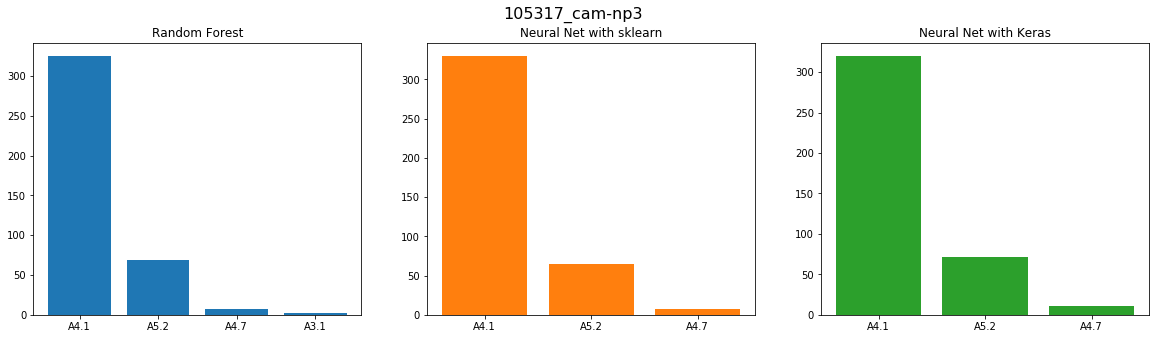

<Figure size 432x288 with 0 Axes>

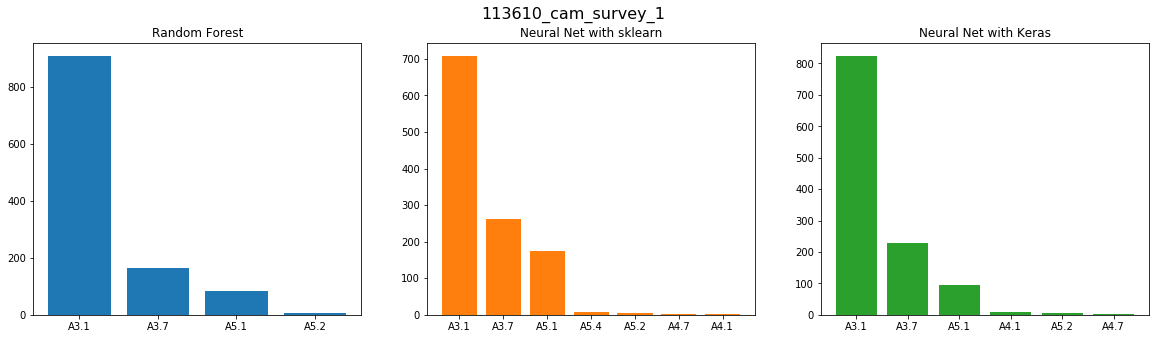

<Figure size 432x288 with 0 Axes>

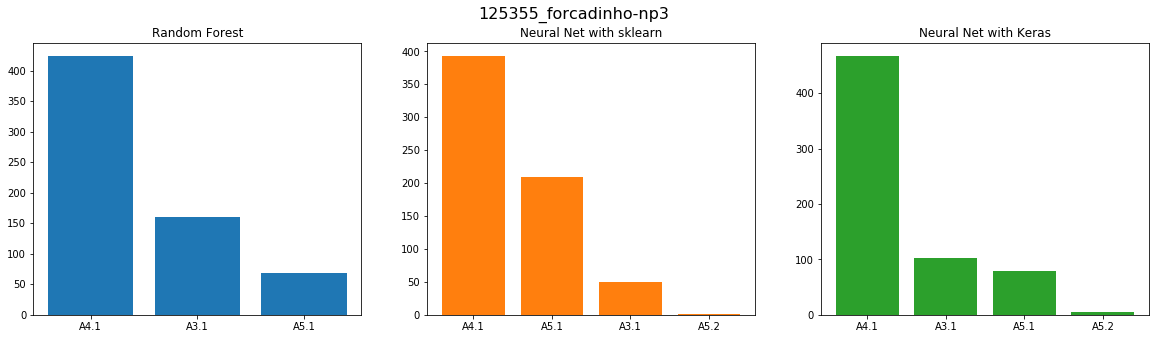

<Figure size 432x288 with 0 Axes>

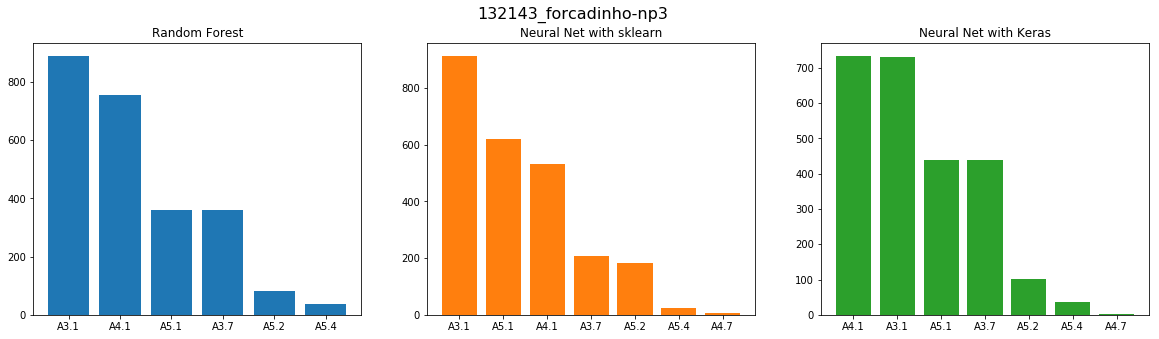

<Figure size 432x288 with 0 Axes>

In [80]:
plt.figure(figsize=(20,5))
plt.suptitle(folders[1], fontsize=16)
plt.subplot(131)
plt.bar(df1_rf_preds.level3.value_counts().index.tolist(), df1_rf_preds.level3.value_counts())
plt.title('Random Forest')
plt.subplot(132)
plt.bar(df1_nn_preds.level3.value_counts().index.tolist(), df1_nn_preds.level3.value_counts(), color='C1')
plt.title('Neural Net with sklearn')
plt.subplot(133)
plt.bar(df1_keras_preds.level3.value_counts().index.tolist(), df1_keras_preds.level3.value_counts(), color='C2')
plt.title('Neural Net with Keras')
plt.show()
plt.savefig('predictions_' + folders[1] + '.jpg')

plt.figure(figsize=(20,5))
plt.suptitle(folders[2], fontsize=16)
plt.subplot(131)
plt.bar(df2_rf_preds.level3.value_counts().index.tolist(), df2_rf_preds.level3.value_counts())
plt.title('Random Forest')
plt.subplot(132)
plt.bar(df2_nn_preds.level3.value_counts().index.tolist(), df2_nn_preds.level3.value_counts(), color='C1')
plt.title('Neural Net with sklearn')
plt.subplot(133)
plt.bar(df2_keras_preds.level3.value_counts().index.tolist(), df2_keras_preds.level3.value_counts(), color='C2')
plt.title('Neural Net with Keras')
plt.show()

plt.savefig('predictions_' + folders[2] + '.jpg')

plt.figure(figsize=(20,5))
plt.suptitle(folders[3], fontsize=16)
plt.subplot(131)
plt.bar(df3_rf_preds.level3.value_counts().index.tolist(), df3_rf_preds.level3.value_counts())
plt.title('Random Forest')
plt.subplot(132)
plt.bar(df3_nn_preds.level3.value_counts().index.tolist(), df3_nn_preds.level3.value_counts(), color='C1')
plt.title('Neural Net with sklearn')
plt.subplot(133)
plt.bar(df3_keras_preds.level3.value_counts().index.tolist(), df3_keras_preds.level3.value_counts(), color='C2')
plt.title('Neural Net with Keras')
plt.show()

plt.savefig('predictions_' + folders[3] + '.jpg')

plt.figure(figsize=(20,5))
plt.suptitle(folders[4], fontsize=16)
plt.subplot(131)
plt.bar(df4_rf_preds.level3.value_counts().index.tolist(), df4_rf_preds.level3.value_counts())
plt.title('Random Forest')
plt.subplot(132)
plt.bar(df4_nn_preds.level3.value_counts().index.tolist(), df4_nn_preds.level3.value_counts(), color='C1')
plt.title('Neural Net with sklearn')
plt.subplot(133)
plt.bar(df4_keras_preds.level3.value_counts().index.tolist(), df4_keras_preds.level3.value_counts(), color='C2')
plt.title('Neural Net with Keras')
plt.show()

plt.savefig('predictions_' + folders[4] + '.jpg')

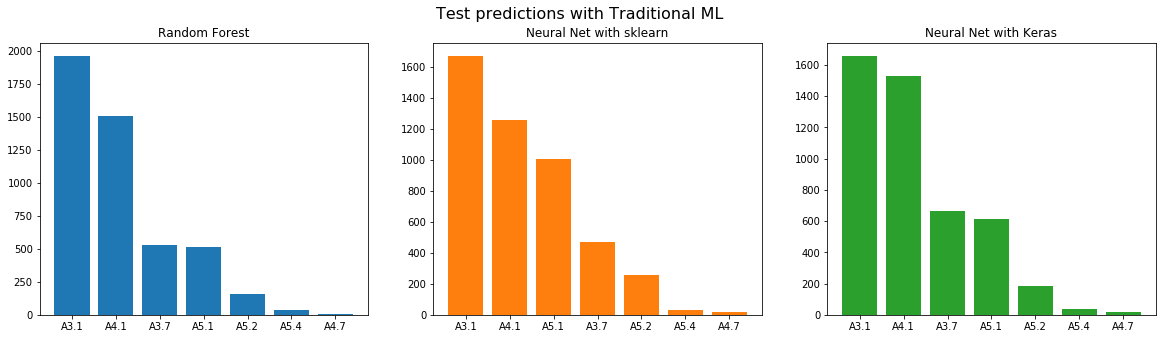

In [81]:
plt.figure(figsize=(20,5))
plt.suptitle('Test predictions with Traditional ML', fontsize=16)
plt.subplot(131)
plt.bar(test_rf_preds.level3.value_counts().index.tolist(), test_rf_preds.level3.value_counts())
plt.title('Random Forest')
plt.subplot(132)
plt.bar(test_nn_preds.level3.value_counts().index.tolist(), test_nn_preds.level3.value_counts(), color='C1')
plt.title('Neural Net with sklearn')
plt.subplot(133)
plt.bar(test_keras_preds.level3.value_counts().index.tolist(), test_keras_preds.level3.value_counts(), color='C2')
plt.title('Neural Net with Keras')
plt.show()

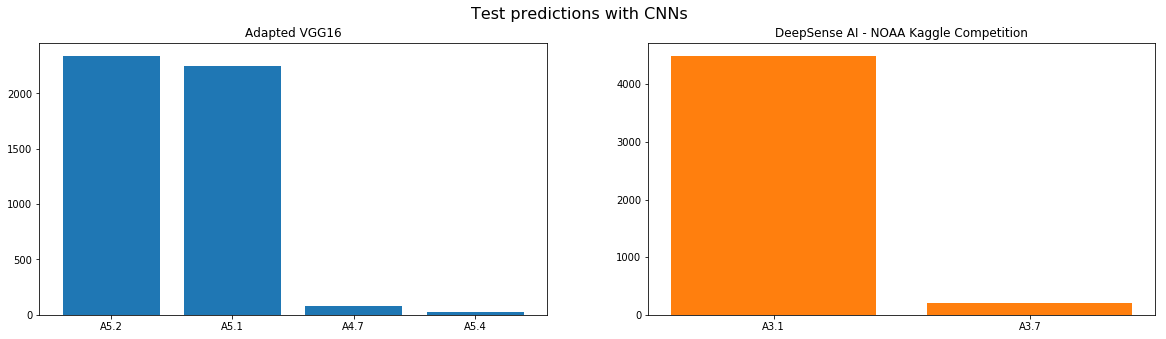

In [62]:
plt.figure(figsize=(20,5))
plt.suptitle('Test predictions with CNNs', fontsize=16)
plt.subplot(121)
plt.bar(vgg16_preds.level3.value_counts().index.tolist(), vgg16_preds.level3.value_counts())
plt.title('Adapted VGG16')
plt.subplot(122)
plt.bar(dsaiNOAA_preds.level3.value_counts().index.tolist(), dsaiNOAA_preds.level3.value_counts(), color='C1')
plt.title('DeepSense AI - NOAA Kaggle Competition')
plt.show()